In [ ]:
!pip install pykeen networkx matplotlib

In [ ]:
import torch
import pykeen
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from pykeen.pipeline import pipeline
from pykeen import datasets
from sklearn.neighbors import NearestNeighbors
from pykeen.evaluation import RankBasedEvaluator
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances, manhattan_distances

In [9]:
dataset = datasets.CoDExSmall()

In [10]:
EPOCHS = 100
MODEL_NAME = "ComplEx"

In [ ]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

In [ ]:
# Задаем параметры для pipeline
pipeline_results = pipeline(
    model=MODEL_NAME,
    dataset=dataset,
    training_kwargs=dict(num_epochs=EPOCHS),
    device=device
)

<Axes: title={'center': 'Losses Plot'}, xlabel='Epoch', ylabel='marginranking Loss'>

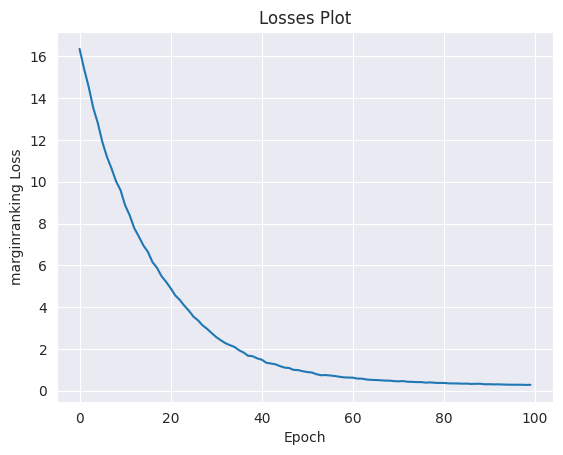

In [13]:
# Обученная модель хранится в pipeline_results
model = pipeline_results.model

#plot loss
pipeline_results.plot_losses()

In [ ]:
# Создаем evaluator объект
evaluator = RankBasedEvaluator()

# Оценить работу модели
metrics = evaluator.evaluate(pipeline_results.model, dataset.testing.mapped_triples,
                             additional_filter_triples=[dataset.training.mapped_triples,
                                                        dataset.validation.mapped_triples])

# Print the metrics
print(f"Hits@1: {metrics.get_metric('hits@1')}")
print(f"Hits@3: {metrics.get_metric('hits@3')}")
print(f"Hits@5: {metrics.get_metric('hits@5')}")
print(f"Hits@10: {metrics.get_metric('hits@10')}")
print(f"Mean Reciprocal Rank: {metrics.get_metric('mean_reciprocal_rank')}")

In [15]:
node_embeddings = pipeline_results.model.entity_representations

embedding_matrix = node_embeddings[0]._embeddings.weight.data

# Конвертируем матрицу весов в NumPy array
embedding_numpy = embedding_matrix.cpu().numpy()

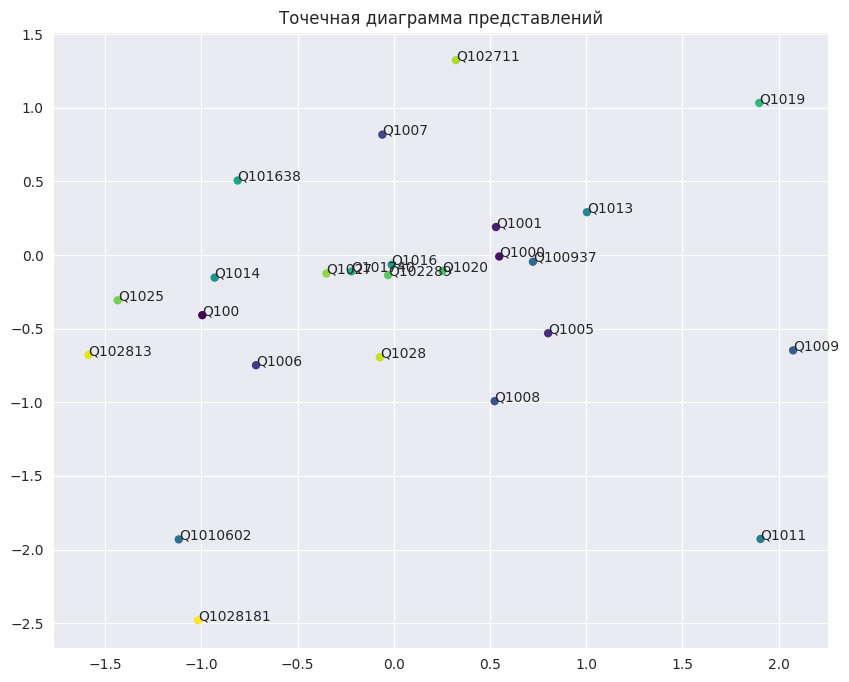

In [16]:
#Созраняем названия сущностей в отдельной переменной
id_to_lable = list(dataset.testing.entity_id_to_label.values())

def visualize_embeddings(embeddings, labels):
    # Scatter plot
    plt.figure(figsize=(10, 8))
    plt.scatter(embeddings[:, 0], embeddings[:, 1], c=np.arange(len(labels)), cmap='viridis', s=25)

    # Добавляем лейблы к точкаи на графике
    for i, label in enumerate(labels):
        plt.annotate(label, (embeddings[i, 0], embeddings[i, 1]), alpha=1)

    plt.title('Точечная диаграмма представлений')
    plt.show()

#Количество точек которые необходимо отобразить на графике
number = 25

visualize_embeddings(embedding_numpy[:number], id_to_lable[:number])

[[ 0.       26.925463 27.148674 29.136347]
 [26.925463  0.       27.152039 27.087402]
 [27.148674 27.152039  0.       27.2937  ]
 [29.136347 27.087402 27.2937    0.      ]]


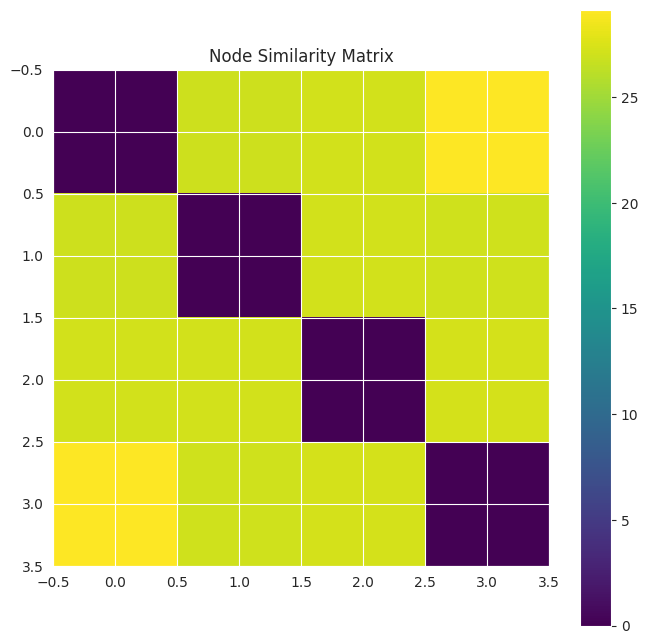

[[ 1.          0.0239179   0.04668147 -0.1297807 ]
 [ 0.0239179   1.0000005   0.01431879 -0.01033563]
 [ 0.04668147  0.01431879  1.0000001   0.01544598]
 [-0.1297807  -0.01033563  0.01544598  0.9999995 ]]


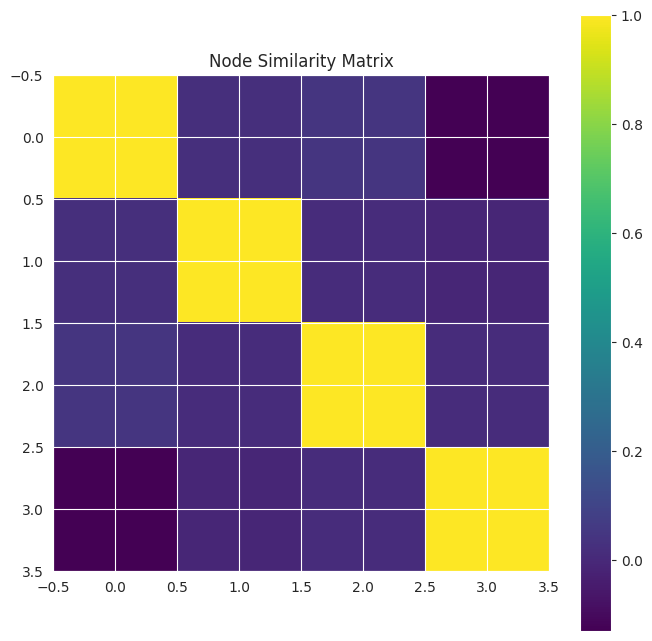

[[  0.         431.06646305 432.51415302 472.4585661 ]
 [431.06646305   0.         435.13597879 424.99911787]
 [432.51415302 435.13597879   0.         429.13224733]
 [472.4585661  424.99911787 429.13224733   0.        ]]


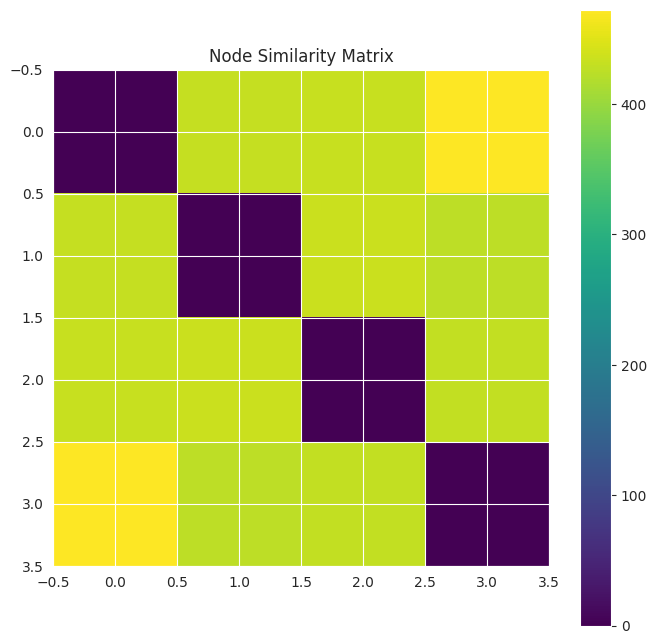

In [17]:
def diplay_matrix(similarity_matrix):
  # Визуализация матрицы близости
  plt.figure(figsize=(8, 8))
  plt.imshow(similarity_matrix, cmap='viridis', interpolation='nearest')
  plt.colorbar()
  plt.title('Node Similarity Matrix')
  plt.show()


# Рассчет близости между узлами
methods = [euclidean_distances,cosine_similarity,manhattan_distances]
#Узлы
nodes = [embedding_numpy[1500],embedding_numpy[2000],embedding_numpy[2030],embedding_numpy[2033]]
for method in methods:
  similarity_matrix = method(nodes)
  print(similarity_matrix)
  diplay_matrix(similarity_matrix)

In [18]:
# Выбираем случайный узел
random_node_index = 777
methods = ['nan_euclidean','cosine','manhattan']
def nearest_nodes(method):
  nn_model = NearestNeighbors(n_neighbors=4, metric=method)
  nn_model.fit(embedding_numpy)
  distances, indices = nn_model.kneighbors([embedding_numpy[random_node_index]])
  print(f'Метрика: {method}')
  print(f'Дистанции:{distances}' )
  print(f'Индексы:{indices}' )
  # Визуализация ближайших соседей
  neighbors_labels = [id_to_lable[i] for i in indices.flatten()]
  print(f"Ближайшие соседи узла {id_to_lable[random_node_index]}: {neighbors_labels} \n")

for method in methods: 
  nearest_nodes(method)

Метрика:nan_euclidean
Дистанции:[[ 0.       24.112259 24.145527 24.194725]]
Индексы:[[ 777 1396  951   79]]
Ближайшие соседи узла Q228909: ['Q228909', 'Q448837', 'Q270935', 'Q107420'] 

Метрика:cosine
Дистанции:[[0.         0.8415357  0.859355   0.85967374]]
Индексы:[[ 777 1396  336  860]]
Ближайшие соседи узла Q228909: ['Q228909', 'Q448837', 'Q156814', 'Q237324'] 

Метрика:manhattan
Дистанции:[[  0.         376.81872559 380.41085815 382.94519043]]
Индексы:[[ 777   79 1281  546]]
Ближайшие соседи узла Q228909: ['Q228909', 'Q107420', 'Q39803', 'Q188482'] 

